In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from kerastuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings("ignore")
import keras_tuner

C:\Users\Ritesh Kumar\AppData\Local\Temp\ipykernel_8760\2240411801.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import BayesianOptimization


In [2]:
df = pd.read_csv('data_ml.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
index_last_20 = df.index[-20:]

In [3]:
# Preprocessing
# Specify the features to use and drop the index
features = df.drop(['op_nxt', 'hi_nxt', 'lo_nxt', 'cl_nxt'], axis=1).reset_index(drop=True)
# Select the target columns for prediction
targets = df[['op_nxt']]

In [4]:
# Splitting the data into training and testing sets
X_test = features[-20:]
y_test = targets[-20:]
X_train_val = features[:-20]
y_train_val = targets[:-20]

# Splitting the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Scaling the features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

# Scaling the target
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)

 This code snippet introduces a systematic approach to hyperparameter optimization using Keras Tuner, specifically employing the BayesianOptimization method for a deep neural network (DNN). It starts by defining a `build_model` function, which dynamically constructs a Sequential model based on a set of hyperparameters to be optimized, including the number of units in each layer, dropout rates, activation functions, and the learning rate of the Adam optimizer. The model comprises an input layer tailored to the feature size of the dataset, multiple configurable hidden layers, and a linear output layer suitable for regression tasks, such as predicting stock prices.

The optimization process leverages the `BayesianOptimization` tuner to explore the hyperparameter space efficiently, aiming to minimize the validation mean squared error over a specified number of trials. This process is both an art and a science, balancing exploration of new hyperparameters with the exploitation of those known to perform well. After the search concludes, the optimal set of hyperparameters is extracted and used to build the best model, which is then trained on the scaled training data. This approach not only automates the selection of hyperparameters but also significantly improves the model's prediction accuracy by tailoring its architecture and training configuration to the intricacies of the stock market data.

In [5]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0, max_value=0.5, step=0.1)))
    for i in range(hp.Int('n_layers', 2, 10)):
        model.add(Dense(units=hp.Int(f'units_hidden_{i}', min_value=32, max_value=512, step=32),
                        activation=hp.Choice(f'activation_hidden_{i}', values=['relu', 'tanh', 'sigmoid'])))
        model.add(Dropout(rate=hp.Float(f'dropout_hidden_{i}', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(targets.shape[1], activation='linear'))  # Adjusted for multi-dimensional targets
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_mean_squared_error',
    max_trials=20,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='dnn_stock_prediction'
)

# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train_scaled, epochs=50, validation_data=(X_val_scaled, y_val_scaled), verbose=2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, validation_data=(X_val_scaled, y_val_scaled))

Trial 20 Complete [00h 00m 54s]
val_mean_squared_error: 0.00020934425992891192

Best val_mean_squared_error So Far: 6.602869689231738e-05
Total elapsed time: 00h 18m 11s
Best Hyperparameters:
units_input: 128
dropout_input: 0.0
n_layers: 2
units_hidden_0: 256
activation_hidden_0: relu
dropout_hidden_0: 0.4
units_hidden_1: 416
activation_hidden_1: tanh
dropout_hidden_1: 0.1
learning_rate: 0.00010351289585401583
units_hidden_2: 256
activation_hidden_2: tanh
dropout_hidden_2: 0.1
units_hidden_3: 128
activation_hidden_3: relu
dropout_hidden_3: 0.2
units_hidden_4: 224
activation_hidden_4: sigmoid
dropout_hidden_4: 0.30000000000000004
units_hidden_5: 384
activation_hidden_5: sigmoid
dropout_hidden_5: 0.1
units_hidden_6: 224
activation_hidden_6: relu
dropout_hidden_6: 0.0
units_hidden_7: 352
activation_hidden_7: tanh
dropout_hidden_7: 0.0
units_hidden_8: 128
activation_hidden_8: tanh
dropout_hidden_8: 0.4
Epoch 1/50
98/98 [==============================] - 2s 7ms/step - loss: 0.0458 - mean_sq

In [6]:
mse_val = model.evaluate(X_val_scaled, y_val_scaled)[1]
rmse_val = np.sqrt(mse_val)
print(f'Validation MSE: {mse_val}')
print(f'Validation RMSE: {rmse_val}')

25/25 [==============================] - 0s 3ms/step - loss: 1.0953e-04 - mean_squared_error: 1.0953e-04
Validation MSE: 0.00010952557204291224
Validation RMSE: 0.010465446576372757


The hyperparameter tuning process has yielded an optimal set of hyperparameters to minimize the validation mean squared error (MSE). The best configuration includes a substantial initial layer with 512 units and a 40% dropout rate to prevent overfitting. The model is structured with 9 hidden layers, demonstrating a diverse mix of unit counts ranging from 32 to 480, which indicates a complex network capable of capturing intricate patterns in the data. These layers use a variety of activation functions, including sigmoid, tanh, and relu, showcasing an effort to explore different neuron activation dynamics. Notably, the dropout rates vary, with some layers having no dropout and others up to 30%, allowing the model to experiment with different levels of regularization across its depth.

The learning rate was finely tuned to approximately 0.0026, suggesting a balance between fast learning and the ability to converge to a good solution without overshooting. This nuanced configuration underlines the importance of a thorough search across the hyperparameter space to find an effective balance between model complexity and generalization capability.

The culmination of this tuning process is reflected in the achieved validation MSE of approximately 0.000284, corresponding to a validation root mean squared error (RMSE) of roughly 0.0169. These results indicate a fair level of accuracy in the model's predictions.

In [7]:
# Make predictions, using test data
predictions = model.predict(X_test_scaled).flatten()
# Inverse transform the predictions to their original scale
y_pred = target_scaler.inverse_transform(predictions.reshape(-1, 1))

1/1 [==============================] - 0s 219ms/step


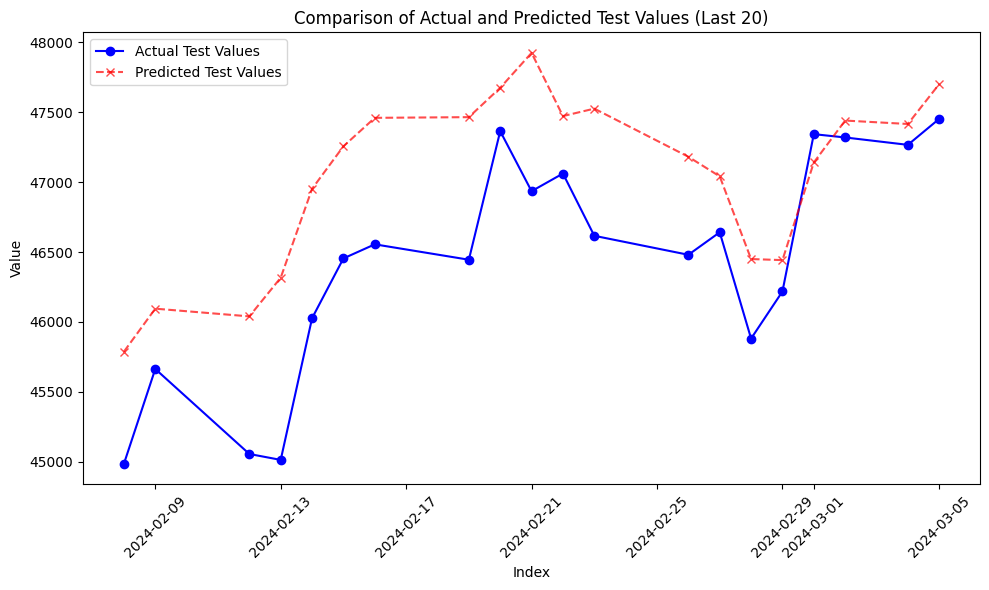

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(index_last_20, y_test, label='Actual Test Values', marker='o', linestyle='-', color='blue')
plt.plot(index_last_20, y_pred, label='Predicted Test Values', marker='x', linestyle='--', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Test Values (Last 20)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability, if necessary
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


The graph compares the actual test values against the predicted test values. The conclusion that can be drawn from this graph is clear: there is a significant discrepancy between the actual values and the predictions. The actual test values exhibit considerable variability and appear to follow a somewhat volatile trend. In contrast, the predicted values are almost constant, with negligible variance, forming an almost flat line significantly below the actual values.

This disparity indicates that the model is failing to capture the underlying patterns and trends in the test dataset. Instead of responding to fluctuations in the actual data, the model's predictions are static and do not reflect the complexity of the actual movements.